<a href="https://colab.research.google.com/github/AhrendsW/PySpark-NLP/blob/main/PySparkNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sessão e leitura dos dados**

In [1]:
!pip install pyspark -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [3]:
spark

### **Explorando os dados**

Agora que já lemos os dados, vamos explorá-lo entendendo:

* O **tamanho** dos dados
* Os **campos** e o tipo
* O **conteúdo** em cada campo
* A **proporção** das categorias


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dados = spark.read.csv("/content/drive/MyDrive/curso-spark/linguagem-natural-spark/data/imdb-reviews-pt-br.csv", escape="\"", header=True, inferSchema=True)

In [6]:
dados.limit(5).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [8]:
print(dados.count(), len(dados.columns))

49459 4


In [9]:
print('Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)
print('Positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [10]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window

dados.groupBy('sentiment').count().withColumn("(%)", f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100, 2)).show()

+---------+-----+-----+
|sentiment|count|  (%)|
+---------+-----+-----+
|      pos|24694|49.93|
|      neg|24765|50.07|
+---------+-----+-----+



### ***Limpando e processando os dados***

Para que o computador compreenda nossa linguagem é importante realizar algumas transformações no intuito de faciliar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplos, remover caracteres especiais e espaços no início e fim dos comentários.


Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições, artigos, pronomes .**..



### **WordCloud**

A nuvem de palavras é um recurso visual muito utilizado para entender as palavras mais frequentes de um texto. Aqui usaremos a própria biblioteca do Python `WordCloud`.

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.


In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
amostra = dados.select('text_pt').sample(False, 0.1, seed=101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

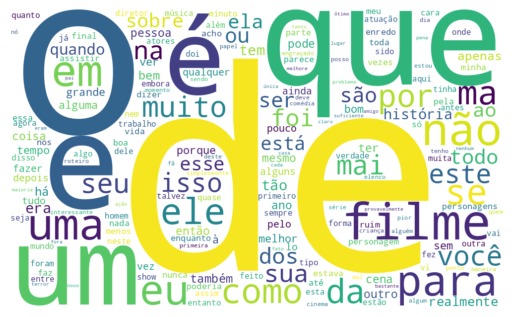

In [13]:
wordcloud = WordCloud(background_color='white', collocations=False, prefer_horizontal=1, width=1000,height=600).generate(str(tudo))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### **Limpeza**: caracteres especiais

In [14]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
dados = dados.withColumn('texto_regex', f.regexp_replace('text_en', "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))
dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))
dados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



#### **Tokenização**: divisão em tokens

In [16]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
tokenizado = tokenizer.transform(dados)

In [17]:
tokenizado.select('texto_limpo', 'tokens').show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [18]:
from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado = tokenizado.withColumn("token_count", countTokens(f.col("tokens")))

In [19]:
tokenizado.select('texto_limpo', 'tokens', 'token_count').show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|token_count|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

#### **StopWords**: remoção de ruídos

Podemos usar o [`StopWordsRemover()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) nativo do spark, ou o [`stopwords()`](https://openbase.com/js/nltk-stopwords/documentation) da biblioteca nltk do Python. Dentre muitas linguagens, ambas bibliotecas dão suporte para o português.

Vamos começar com um **exemplo pequeno** e depois aplicar em nossos dados.

In [20]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_A = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol='tokens', outputCol='sem_stop', stopWords=stop_A)
sem_stop = remover.transform(tokenizado)

In [22]:
sem_stop.select('texto_limpo', 'tokens', 'sem_stop').show()

+--------------------+--------------------+--------------------+
|         texto_limpo|              tokens|            sem_stop|
+--------------------+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|Not even the Beat...|[not, even, the, ...|[even, beatles, c...|
|Brass pictures mo...|[brass, pictures,...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|[funny, thing, ha...|
|This German horro...|[this, german, ho...|[german, horror, ...|
|Being a longtime ...|[being, a, longti...|[longtime, fan, j...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|[cage, plays, dru...|
|First of all I wo...|[first, of, all, ...|[first, would, li...|
|So tell me  what ...|[so

In [23]:
sem_stop.columns

['id',
 'text_en',
 'text_pt',
 'sentiment',
 'texto_regex',
 'texto_limpo',
 'tokens',
 'token_count',
 'sem_stop']

In [24]:
sem_stop.select('tokens', 'texto_limpo', 'sem_stop') \
    .withColumn("token_count", countTokens(f.col("tokens"))) \
    .withColumn("stop_count", countTokens(f.col("sem_stop"))) \
    .show()

+--------------------+--------------------+--------------------+-----------+----------+
|              tokens|         texto_limpo|            sem_stop|token_count|stop_count|
+--------------------+--------------------+--------------------+-----------+----------+
|[once, again, mr,...|Once again Mr Cos...|[mr, costner, dra...|        168|        74|
|[this, is, an, ex...|This is an exampl...|[example, majorit...|        232|       131|
|[first, of, all, ...|First of all I ha...|[first, hate, mor...|        215|       111|
|[not, even, the, ...|Not even the Beat...|[even, beatles, c...|        308|       170|
|[brass, pictures,...|Brass pictures mo...|[brass, pictures,...|        238|       140|
|[a, funny, thing,...|A funny thing hap...|[funny, thing, ha...|        115|        53|
|[this, german, ho...|This German horro...|[german, horror, ...|        156|        75|
|[being, a, longti...|Being a longtime ...|[longtime, fan, j...|        136|        74|
|[tokyo, eyes, tel...|Tokyo Eyes

### **Vetorização**


A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados.


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos.

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...



In [25]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol='sem_stop', outputCol='vetor')
modelo = cv.fit(sem_stop)
vetorizado = modelo.transform(sem_stop)

In [26]:
vetorizado.select('sem_stop', 'vetor').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
modelo.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'would',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'first',
 'dont',
 'movies',
 'made',
 'make',
 'films',
 'could',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'say',
 'still',
 'end',
 'scene',
 'scenes',
 'man',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'thing',
 'actors',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'director',
 'quite',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'thought',
 'enough',
 'give',
 'world',
 'big',
 'horror',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'alwa

# Countvectorizer

from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()#truncate=False

In [28]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol='sem_stop', outputCol='vetor')
modelo = cv.fit(sem_stop)
vetorizado = modelo.transform(sem_stop)

vetorizado.select('sem_stop','vetor').limit(5).show()

+--------------------+--------------------+
|            sem_stop|               vetor|
+--------------------+--------------------+
|[mr, costner, dra...|(216699,[0,8,9,12...|
|[example, majorit...|(216699,[1,2,3,9,...|
|[first, hate, mor...|(216699,[0,2,4,12...|
|[even, beatles, c...|(216699,[0,1,2,4,...|
|[brass, pictures,...|(216699,[1,3,5,9,...|
+--------------------+--------------------+



#### **[Hashing TF](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.HashingTF.html)**: alternativa para o Countvector

É gerado a mesma estrutura, entretando aqui limitamos o número de palavras contabilizadas.

In [29]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol='sem_stop', outputCol='rawFeatures', numFeatures=50)
HTFfeaturizedData = hashingTF.transform(sem_stop)

In [30]:
HTFfeaturizedData.select('sem_stop', 'rawFeatures').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **TF-IDF**: estabelecendo pesos

O TF-IDF não apenas contabiliza as diferentes palavras, mas também gera pesos para cada um a partir da predomância nos dados.

In [31]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(HTFfeaturizedData)
rescaledData = idfModel.transform(HTFfeaturizedData)

In [32]:
rescaledData.select('sem_stop', 'rawFeatures', 'features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Codificando**: variável resposta.
Lembrando que ensinaremos que todas essas palavras estarão associadas ao sentimento do depoimento, positivo ou negativo, entretando precisamos codificar `neg` e `pos` para 0 e 1 e podemos usar o `StringIndexer`



In [33]:
rescaledData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [34]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='sentiment', outputCol='label')
indexed = indexer.fit(rescaledData).transform(rescaledData)

In [35]:
indexed.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



#### **Pipeline**: Transformação dos dados

In [36]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='sem_stop')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='rawFeatures', numFeatures=1000)
idf = IDF(inputCol='rawFeatures', outputCol='features')
indexer = StringIndexer(inputCol='sentiment', outputCol='label')

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, idf, indexer])

In [37]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [38]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|            sem_stop|         rawFeatures|            features|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|  0.0|
|  3|First of all I ha...|Primeiro de tudo ...|   

### **Modelo**

Nosso objetivo é consguir identificar um comentário negativo ou positivo, para isso precisamos criar um modelo em que o computador consiga classificar os depoimentos. Agora que já processamos nossos dados podemos construir um **modelo de classificação**, veja alguma opções:

* Regressão Logística
* Árvore de Decisão
* Florestas Aleatórias
* GX boost
* entre outros...

Para testar nossos dados usaremos todos os procedimentos realizados em Limpeza e processamento dos dados e a vetorização que estabelece pesos para as palavras construidas a partir do TF-IDF.





In [39]:
featureDF = dados_transformados.select('features', 'label')

In [40]:
featureDF.limit(5).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+



In [41]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



### **Separação entre treino e teste**

In [42]:
# Divisão dos dados entre treino e teste
train_data, test_data = dados.randomSplit([0.7, 0.3], seed=101)

### **Criação de pipelines para cada modelo**

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Etapas de pré-processamento
tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='sem_stop')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='rawFeatures', numFeatures=1000)
idf = IDF(inputCol='rawFeatures', outputCol='features')

# Modelos de classificação
lr = LogisticRegression(featuresCol='features', labelCol='label')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
gbt = GBTClassifier(featuresCol='features', labelCol='label')

# Criação das pipelines para cada modelo
pipeline_lr = Pipeline(stages=[tokenizer, stopwords, hashingTF, idf, indexer, lr])
pipeline_dt = Pipeline(stages=[tokenizer, stopwords, hashingTF, idf, indexer, dt])
pipeline_rf = Pipeline(stages=[tokenizer, stopwords, hashingTF, idf, indexer, rf])
pipeline_gbt = Pipeline(stages=[tokenizer, stopwords, hashingTF, idf, indexer, gbt])

### **Criação das métricas avaliadoras**

In [78]:
# Avaliador para cada métrica
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
evaluator_precision = MulticlassClassificationEvaluator(labelCol='label', metricName='precisionByLabel')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='label', metricName='recallByLabel')
evaluator_fmeasure = MulticlassClassificationEvaluator(labelCol='label', metricName='fMeasureByLabel')

### **Criação dos parâmetros de cada modelo**

In [79]:
# Validação cruzada
paramGrid = ParamGridBuilder().build()

In [80]:
# Parâmetros simplificados para CrossValidator com seed
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10])\
    .addGrid(dt.maxBins, [15, 33]) \
    .build()

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10])\
    .addGrid(rf.maxBins, [10, 22])\
    .addGrid(rf.numTrees, [15, 30])\
    .build()

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

### **Criação da validação cruzada de cada modelo**

In [81]:
cv_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_precision, numFolds=3, seed=101)
cv_dt = CrossValidator(estimator=pipeline_dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_precision, numFolds=3, seed=101)
cv_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_precision, numFolds=3, seed=101)
cv_gbt = CrossValidator(estimator=pipeline_gbt, estimatorParamMaps=paramGrid_gbt, evaluator=evaluator_precision, numFolds=3, seed=101)

### **Treinando os modelos**

In [82]:
# Treinamento e avaliação
models = {'Logistic Regression': cv_lr, 'Decision Tree': cv_dt, 'Random Forest': cv_rf, 'GBT': cv_gbt}

In [83]:
# Dicionário para armazenar os modelos treinados
trained_models = {}

# Treinamento e avaliação
for name, model in models.items():
    cv_model = model.fit(train_data)

    # Armazenar o modelo treinado no dicionário
    trained_models[name] = cv_model

    # Obtenção das métricas
    accuracy = evaluator_accuracy.evaluate(cv_model.transform(test_data))
    precision = evaluator_precision.evaluate(cv_model.transform(test_data))
    recall = evaluator_recall.evaluate(cv_model.transform(test_data))
    fmeasure = evaluator_fmeasure.evaluate(cv_model.transform(test_data))

    print(f'{name} Accuracy: {accuracy:.4f}')
    print(f'{name} Precision: {precision:.4f}')
    print(f'{name} Recall: {recall:.4f}')
    print(f'{name} F-Measure: {fmeasure:.4f}')
    print('-' * 30)

Logistic Regression Accuracy: 0.8061
Logistic Regression Precision: 0.8005
Logistic Regression Recall: 0.8080
Logistic Regression F-Measure: 0.8043
------------------------------
Decision Tree Accuracy: 0.6727
Decision Tree Precision: 0.6494
Decision Tree Recall: 0.7308
Decision Tree F-Measure: 0.6877
------------------------------
Random Forest Accuracy: 0.7399
Random Forest Precision: 0.7128
Random Forest Recall: 0.7916
Random Forest F-Measure: 0.7501
------------------------------
GBT Accuracy: 0.7275
GBT Precision: 0.7071
GBT Recall: 0.7635
GBT F-Measure: 0.7342
------------------------------


### **Nova frase**

In [110]:
# Criando novos dados de entrada
nova_base = spark.createDataFrame([
    (1, "I thought this movie was horrible, bad acting"),
    (0, "I loved this movie, I swear, I feel like it was the best movie I saw this year!"),
    ], ["id", "texto_limpo"])

nova_base.limit(5).show(truncate=False)

+---+-------------------------------------------------------------------------------+
|id |texto_limpo                                                                    |
+---+-------------------------------------------------------------------------------+
|1  |I thought this movie was horrible, bad acting                                  |
|0  |I loved this movie, I swear, I feel like it was the best movie I saw this year!|
+---+-------------------------------------------------------------------------------+



In [111]:
# Modelo utilizado
model_lr_cv = trained_models['Logistic Regression']

In [112]:
# Aplicando modelo aos dados de entrada
nova_class = model_lr_cv.transform(nova_base)

In [113]:
nova_class.limit(5).show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|         texto_limpo|              tokens|            sem_stop|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|I thought this mo...|[i, thought, this...|[thought, movie, ...|(1000,[42,55,439,...|(1000,[42,55,439,...|[-0.6983254082981...|[0.33218361088135...|       1.0|
|  0|I loved this movi...|[i, loved, this, ...|[loved, movie,, s...|(1000,[115,330,39...|(1000,[115,330,39...|[0.79720401098421...|[0.68937607450202...|       0.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+

